# Using the lmt-analysis library with Jupyter - Level 2

We show here some more advanced examples of Live Mouse Tracker analysis.

Video demo and available databases: https://livemousetracker.org/
Paper : https://www.biorxiv.org/content/10.1101/345132v2
mail: chaumont@pasteur.fr, elodie.ey@pasteur.fr
Twitter : @fabdechaumont
Another tutorial of the this lib (slide presentation): https://docs.google.com/presentation/d/1wR7JM2vq5ZjugrwDe4YuuKJm0MWIvkHAvrOH7mQNOEk/edit?usp=sharing

How to use run this tutorial with your data:
1. Download or connect a git client to the lmt-analysis repository : https://github.com/fdechaumont/lmt-analysis
2. Download the demo database produced by Live Mouse Tracker: http://bioimageanalysis.org
3. Install anaconda, and run the jupyter notebook: https://www.anaconda.com/distribution/
4. Point your browser to this file (example/Examples with Jupyter)
/lmt/20180110_validation_4_ind_Experiment_6644.zip
5. Run
6. Select the database you just downloaded when asked.
7. Enjoy the results.

In this demo, we will use widgets to make the analysis interactive with the user.

In [1]:
'''
Created on 15 fev. 2019

@author: Fab
'''

import sys
sys.path.insert(1, "../")


import pandas as pd
import numpy as np

import sqlite3
from lmtanalysis.FileUtil import getFilesToProcess

from lmtanalysis.Animal import AnimalPool
from lmtanalysis.Animal import Animal
from lmtanalysis.Measure import *
from lmtanalysis.Event import EventTimeLine, plotMultipleTimeLine

from lmtanalysis.Util import convert_to_d_h_m_s
from lmtanalysis.Util import d_h_m_s_toText

from lmtanalysis.Measure import oneDay

# widgets

import ipywidgets as widgets
from IPython.display import display
from IPython.core.display import HTML

## Ask file to process to the user with a dialog window:
* note: You can run this step only once, and then keep processing the file(s) with the next cells.
* note2: the file window can be hidden by other windows.

In [2]:
#ask the user for database to process
files = getFilesToProcess()

## Grab all events and animals available, and create widgets with it.
* We create a widget with all events available
* We create a widget with all the animals available

In [3]:

def getAllEvents( file ):
    print( "Loading events...")
    connection = sqlite3.connect( file )
    query = "select name from event group by name"
    c = connection.cursor()     
    c.execute( query )    
    all_rows = c.fetchall()        
    header = [ "Name" ]
    data =[]    
    for row in all_rows:
        data.append( row[0] )
    return data


file = files[0]
eventList = getAllEvents( file )

connection = sqlite3.connect( file )
animalPool = AnimalPool()
animalPool.loadAnimals( connection )


animalIdList = []
animalIdList.append( "Any animal" )
for animalKey in animalPool.getAnimalDictionnary():
    animal = animalPool.getAnimalDictionnary()[animalKey]
    animalIdList.append( animal )
    

eventWidget = widgets.Dropdown(
    options=eventList,    
    description='Event name:',
    disabled=False,
)

animalWidget = {}
animalWidget['A'] = widgets.Dropdown( options=animalIdList, description='Animal A:' )
animalWidget['B'] = widgets.Dropdown( options=animalIdList, description='Animal B:' )
animalWidget['C'] = widgets.Dropdown( options=animalIdList, description='Animal C:' )
animalWidget['D'] = widgets.Dropdown( options=animalIdList, description='Animal D:' )

display( eventWidget )
display( animalWidget['A'] )
display( animalWidget['B'] )
display( animalWidget['C'] )
display( animalWidget['D'] )

startFrameWidget = widgets.IntText( value=0, description='Start time (in frame):' )
endFrameWidget = widgets.IntText( value= oneDay, description='End time (in frame):' )
display( startFrameWidget , endFrameWidget )


Loading events...
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004395862 Genotype:None User1:None
Animal Id:2 Name:B RFID:000004395854 Genotype:None User1:None
Animal Id:3 Name:C RFID:000004396001 Genotype:None User1:None
Animal Id:4 Name:D RFID:000004395671 Genotype:None User1:None


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

# Provide a result with selected event and animals

Event selected:  Stop
Animal A:  Animal Id:1 Name:A RFID:000004395862 Genotype:None User1:None
Animal B:  Any animal
Animal C:  Any animal
Animal D:  Any animal
Start time:  0 days 0 hours 0 minutes 0 seconds 0 frames
End time:  1 days 0 hours 0 minutes 0 seconds 0 frames
Stop  Id( 1 , None , None , None ) Loaded ( 732  records loaded in  0.10501599311828613 S )


,Start frame,End frame,Duration (in frame)
0,29,37,9
1,48,52,5
2,61,71,11
3,81,86,6
4,98,124,27
5,184,196,13
6,199,226,28
7,229,232,4
8,237,261,25
9,269,280,12


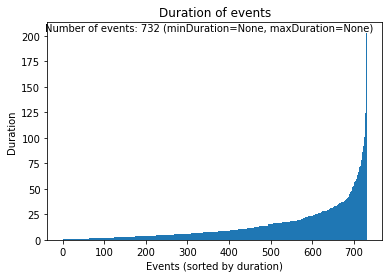

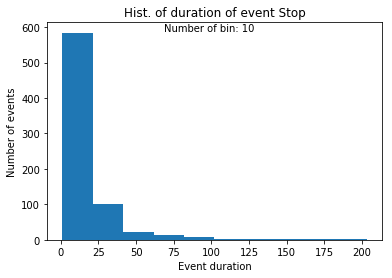

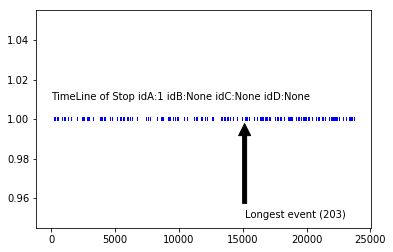

Animal Id:1 Name:A RFID:000004395862 Genotype:None User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y, MASS_Z, FRONT_X, FRONT_Y, FRONT_Z, BACK_X, BACK_Y, BACK_Z,REARING,LOOK_UP,LOOK_DOWN FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=2592000
Animal Id:1 Name:A RFID:000004395862 Genotype:None User1:None   23873  detections loaded in 0.7429814338684082 seconds.
Animal Id:2 Name:B RFID:000004395854 Genotype:None User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y, MASS_Z, FRONT_X, FRONT_Y, FRONT_Z, BACK_X, BACK_Y, BACK_Z,REARING,LOOK_UP,LOOK_DOWN FROM DETECTION WHERE ANIMALID=2 AND FRAMENUMBER>=0 AND FRAMENUMBER<=2592000
Animal Id:2 Name:B RFID:000004395854 Genotype:None User1:None   23863  detections loaded in 0.7480030059814453 seconds.
Animal Id:3 Name:C RFID:000004396001 Genotype:None User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y, MASS_Z, FRONT_X, FRONT_Y, FRONT_Z, BACK_X, BACK_Y, BACK_Z,REARING,LOOK_UP,LOOK_DOWN

Draw trajectory of animal A


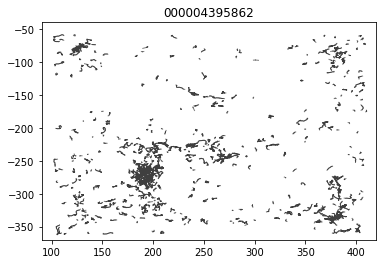

Draw trajectory of animal B


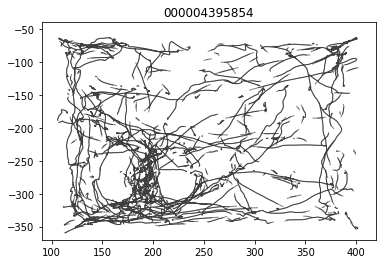

Draw trajectory of animal C


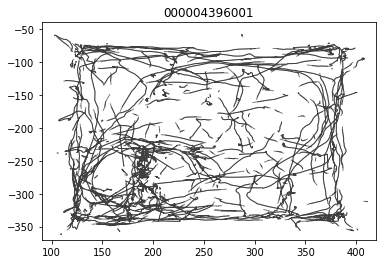

Draw trajectory of animal D


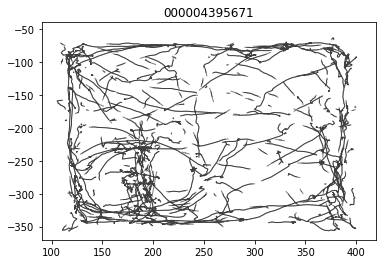

In [6]:
def getAnimalBaseIdFromWidget( value ):
    if type(value) is Animal:
        return value.baseId
    return None

def printBold( txt , color="black"):
    display(HTML("<font color={}><h1>{}</h1></font>".format( color, txt ) ))    
    
def isInvolved( animal ):
    """ Check if the animal is involved in the current query """
    for k in animalWidget:
        id = getAnimalBaseIdFromWidget( animalWidget[k].value )
        if ( id== animal.baseId ):
            return True
    return False            

print( "Event selected: ", eventWidget.value )
print( "Animal A: " , animalWidget['A'].value )
print( "Animal B: " , animalWidget['B'].value )
print( "Animal C: " , animalWidget['C'].value )
print( "Animal D: " , animalWidget['D'].value )

minFrame = startFrameWidget.value
maxFrame = endFrameWidget.value

print ( "Start time: ", d_h_m_s_toText ( convert_to_d_h_m_s( minFrame ) ) )
print ( "End time: ", d_h_m_s_toText ( convert_to_d_h_m_s( maxFrame ) ) )

idA = getAnimalBaseIdFromWidget( animalWidget['A'].value )
idB = getAnimalBaseIdFromWidget( animalWidget['B'].value )
idC = getAnimalBaseIdFromWidget( animalWidget['C'].value )
idD = getAnimalBaseIdFromWidget( animalWidget['D'].value )

eventTimeLine = EventTimeLine( connection, eventWidget.value, idA = idA, idB = idB, idC = idC, idD = idD, minFrame = minFrame, maxFrame = maxFrame )        

printBold( eventTimeLine )
# display number of events:
printBold( "Number of events : " + str(eventTimeLine.getNumberOfEvent()) , color = "red" )

# display events in time line
data = []
    
for event in eventTimeLine.eventList:
    data.append( [ event.startFrame, event.endFrame, event.duration() ] )
    #print( event.startFrame, event.endFrame, event.duration() )

df = pd.DataFrame( data = np.array( data ), columns=[ "Start frame","End frame", "Duration (in frame)" ] )
display( df )

printBold( "Distribution of duration of events:" )
eventTimeLine.plotEventDurationDistributionBar()
printBold( "Distribution of duration of events in bins:" )
eventTimeLine.plotEventDurationDistributionHist()
printBold( "Time line of event:" )
eventTimeLine.plotTimeLine()

#show location of events

animalPool.loadDetection( start= minFrame, end = maxFrame )
animalPool.filterDetectionByEventTimeLine( eventTimeLine )

for animalKey in animalPool.getAnimalDictionnary():
    animal = animalPool.getAnimalDictionnary()[animalKey]
    
    if isInvolved( animal ) :
        printBold( "involved", color ="green")        
    else:
        printBold( "this animal not involved in event definition", color ="red" )
    
    animal.plotTrajectory()

